<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250px"/>

# Feature Importance
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2021 University of Illinois Board of Trustees. All Rights Reserved.

# imports and graphics configurations

In [ ]:
import os
import numpy
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
import sklearn.linear_model
import sklearn.model_selection
import itertools

def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")

def legend(pos="bottom",ncol=3):
    if pos=="bottom":
        plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5
}
plt.rcParams.update(params)

In [ ]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
print([os.remove(f) for f in pngfiles])

existing png files: ['accuracies.png', 'daccuracies.png', 'lr.png', 'lracc.png', 'model00.png', 'model01.png', 'model10.png', 'permutationimportance.png', 'points.png', 'points_xpermute.png', 'points_ypermute.png', 'sampledpermutationimportance.png', 'Shapley.png']
[None, None, None, None, None, None, None, None, None, None, None, None, None]


In [ ]:
import sklearn.linear_model
import sklearn.utils

# configuration variables

In [ ]:
SEED=0
xymax=2.5

In [ ]:
N_points=100
(m,b)=(0.3,0.2)
eps=0.5

# main

In [ ]:
data=pandas.DataFrame(scipy.stats.norm.rvs(size=(N_points,2),random_state=SEED),columns=["x","y"])
data["label"]=(data["y"]>m*data["x"]+b+scipy.stats.norm.rvs(size=N_points,scale=eps,random_state=SEED)).astype(numpy.int)
data.index+=1
data.index.name="record"
data.head()

C:\Users\richa\AppData\Local\Temp/ipykernel_19044/1916254348.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data["label"]=(data["y"]>m*data["x"]+b+scipy.stats.norm.rvs(size=N_points,scale=eps,random_state=SEED)).astype(numpy.int)


,x,y,label
record,,,
1,1.764052,0.400157,0
2,0.978738,2.240893,1
3,1.867558,-0.977278,0
4,0.950088,-0.151357,0
5,-0.103219,0.410599,0


In [ ]:
data.head().to_latex(buf="data.tex",bold_rows=True)
data.head()

,x,y,label
record,,,
1,1.764052,0.400157,0
2,0.978738,2.240893,1
3,1.867558,-0.977278,0
4,0.950088,-0.151357,0
5,-0.103219,0.410599,0


C:\Users\richa\AppData\Local\Temp/ipykernel_19044/1378194212.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flags=data["label"].astype(numpy.bool)


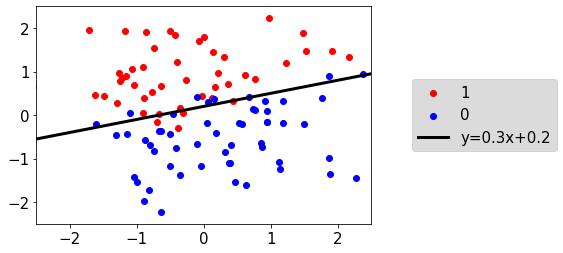

In [ ]:
flags=data["label"].astype(numpy.bool)
plt.figure()
plt.scatter(data.loc[flags,"x"],data.loc[flags,"y"],color="red",label="1")
plt.scatter(data.loc[~flags,"x"],data.loc[~flags,"y"],color="blue",label="0")
xrange=numpy.array([-xymax,xymax])
plt.xlim(-xymax,xymax)
plt.ylim(-xymax,xymax)
plt.plot(xrange,m*xrange+b,color="black",linewidth=3,label="y={m:.1f}x+{b:.1f}".format(m=m,b=b))
legend("side")
saver("points")
plt.show()
plt.close()

In [ ]:
lr = sklearn.linear_model.LogisticRegression(random_state=SEED,solver='lbfgs').fit(data[["x","y"]], data["label"])
model=lr.predict

In [ ]:
lr_b=lr.intercept_.item()
(lr_mx,lr_my)=lr.coef_.squeeze()
lr_m=-lr_mx/lr_my
lr_b=-lr_b/lr_my

In [ ]:
accuracy=1-numpy.mean(numpy.abs(model(data[["x","y"]])-data["label"]))

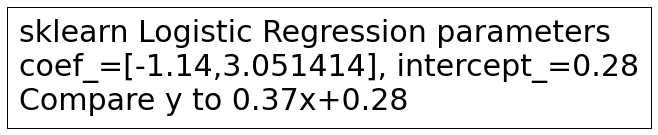

In [ ]:
text=[]
text.append("sklearn Logistic Regression parameters")
text.append("coef_=[{c1:.2f},{c2:2f}], intercept_={b:.2f}".format(c1=lr_mx,c2=lr_my,b=lr_b))
text.append("Compare y to {m:.2f}x{b:+.2f}".format(m=lr_m,b=lr_b))
textbox(text,fname="lr")

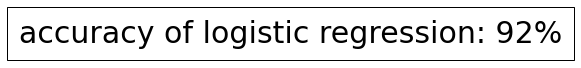

In [ ]:
text=[]
text.append("accuracy of logistic regression: {acc:.0%}".format(acc=accuracy))
textbox(text,fname="lracc")

In [ ]:
datatwo=data.iloc[:2,:]
datatwo

,x,y,label
record,,,
1,1.764052,0.400157,0
2,0.978738,2.240893,1


In [ ]:
datatwo_tildeDx=datatwo.copy()
datatwo_tildeDx["x"]=list(datatwo_tildeDx["x"].reindex(index=datatwo_tildeDx.index[::-1]))
datatwo_tildeDx

,x,y,label
record,,,
1,0.978738,0.400157,0
2,1.764052,2.240893,1


In [ ]:
datatwo_tildeDy=datatwo.copy()
datatwo_tildeDy["y"]=list(datatwo_tildeDx["y"].reindex(index=datatwo_tildeDx.index[::-1]))
datatwo_tildeDy

,x,y,label
record,,,
1,1.764052,2.240893,0
2,0.978738,0.400157,1


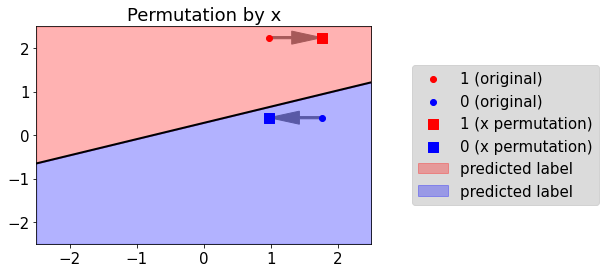

In [ ]:
flagsdatatwo=datatwo["label"].astype(bool)
flagsdatatwo_tildeDx=datatwo_tildeDx["label"].astype(bool)
plt.figure()
plt.scatter(datatwo.loc[flagsdatatwo,"x"],datatwo.loc[flagsdatatwo,"y"],color="red",label="1 (original)",zorder=5)
plt.scatter(datatwo.loc[~flagsdatatwo,"x"],datatwo.loc[~flagsdatatwo,"y"],color="blue",label="0 (original)",zorder=5)
plt.scatter(datatwo_tildeDx.loc[flagsdatatwo_tildeDx,"x"],datatwo_tildeDx.loc[flagsdatatwo_tildeDx,"y"],
            marker="s",s=100,color="red",label="1 (x permutation)",zorder=5)
plt.scatter(datatwo_tildeDx.loc[~flagsdatatwo_tildeDx,"x"],datatwo_tildeDx.loc[~flagsdatatwo_tildeDx,"y"],
            marker="s",s=100,color="blue",label="0 (x permutation)",zorder=5)
plt.arrow(datatwo["x"][1],datatwo["y"][1],datatwo_tildeDx["x"][1]-datatwo["x"][1],datatwo_tildeDx["y"][1]-datatwo["y"][1],
         width=0.05,length_includes_head=True,head_width=.3,color="grey")
plt.arrow(datatwo["x"][2],datatwo["y"][2],datatwo_tildeDx["x"][2]-datatwo["x"][2],datatwo_tildeDx["y"][2]-datatwo["y"][2],
         width=0.05,length_includes_head=True,head_width=.3,color="grey")
xrange=numpy.array([-xymax,xymax])
plt.fill_between(xrange,y1=lr_m*xrange+lr_b,y2=xymax,color="red",alpha=0.3,label="predicted label")
plt.fill_between(xrange,y1=-xymax,y2=lr_m*xrange+lr_b,color="blue",alpha=0.3,label="predicted label")
plt.plot(xrange,lr_m*xrange+lr_b,color="black",linewidth=2,zorder=10)
plt.xlim(-xymax,xymax)
plt.ylim(-xymax,xymax)
legend("side")
title=[]
title.append("Permutation by x")
plt.title("\n".join(title))
saver("points_xpermute")
plt.show()
plt.close()

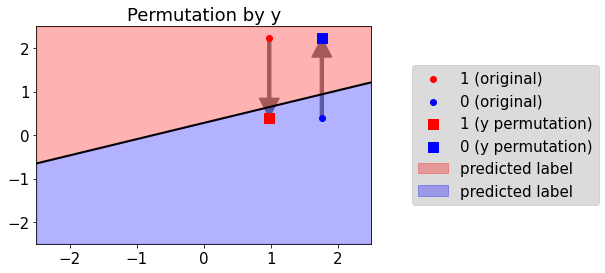

In [ ]:
flagsdatatwo=datatwo["label"].astype(bool)
flagsdatatwo_tildeDy=datatwo_tildeDy["label"].astype(bool)
plt.figure()
plt.scatter(datatwo.loc[flagsdatatwo,"x"],datatwo.loc[flagsdatatwo,"y"],color="red",label="1 (original)",zorder=5)
plt.scatter(datatwo.loc[~flagsdatatwo,"x"],datatwo.loc[~flagsdatatwo,"y"],color="blue",label="0 (original)",zorder=5)
plt.scatter(datatwo_tildeDy.loc[flagsdatatwo_tildeDy,"x"],datatwo_tildeDy.loc[flagsdatatwo_tildeDy,"y"],
            marker="s",s=100,color="red",label="1 (y permutation)",zorder=5)
plt.scatter(datatwo_tildeDy.loc[~flagsdatatwo_tildeDy,"x"],datatwo_tildeDy.loc[~flagsdatatwo_tildeDy,"y"],
            marker="s",s=100,color="blue",label="0 (y permutation)",zorder=5)
plt.arrow(datatwo["x"][1],datatwo["y"][1],datatwo_tildeDy["x"][1]-datatwo["x"][1],datatwo_tildeDy["y"][1]-datatwo["y"][1],
         width=0.05,length_includes_head=True,head_width=.3,color="grey")
plt.arrow(datatwo["x"][2],datatwo["y"][2],datatwo_tildeDy["x"][2]-datatwo["x"][2],datatwo_tildeDy["y"][2]-datatwo["y"][2],
         width=0.05,length_includes_head=True,head_width=.3,color="grey")
xrange=numpy.array([-xymax,xymax])
plt.fill_between(xrange,y1=lr_m*xrange+lr_b,y2=xymax,color="red",alpha=0.3,label="predicted label")
plt.fill_between(xrange,y1=-xymax,y2=lr_m*xrange+lr_b,color="blue",alpha=0.3,label="predicted label")
plt.plot(xrange,lr_m*xrange+lr_b,color="black",linewidth=2,zorder=10)
plt.xlim(-xymax,xymax)
plt.ylim(-xymax,xymax)
legend("side")
title=[]
title.append("Permutation by y")
plt.title("\n".join(title))
saver("points_ypermute")
plt.show()
plt.close()

In [ ]:
tildeDx=data.copy()
tildeDx["x"]=sklearn.utils.shuffle(tildeDx["x"].values,random_state=SEED)
accuracy_tildeDx=1-numpy.mean(numpy.abs(model(tildeDx[["x","y"]])-tildeDx["label"]))

In [ ]:
tildeDx.head().to_latex(buf="datashufflex.tex",bold_rows=True)
tildeDx.head()

,x,y,label
record,,,
1,-0.510805,0.400157,0
2,0.856831,2.240893,1
3,1.867558,-0.977278,0
4,1.867559,-0.151357,0
5,-0.068242,0.410599,0


In [ ]:
tildeDy=data.copy()
tildeDy["y"]=sklearn.utils.shuffle(tildeDy["y"].values,random_state=SEED)
accuracy_tildeDy=1-numpy.mean(numpy.abs(model(tildeDy[["x","y"]])-tildeDy["label"]))

In [ ]:
tildeDy.head().to_latex(buf="datashuffley.tex",bold_rows=True)
tildeDy.head()

,x,y,label
record,,,
1,1.764052,-1.180632,0
2,0.978738,-0.651026,1
3,1.867558,-0.977278,0
4,0.950088,0.906045,0
5,-0.103219,1.713343,0


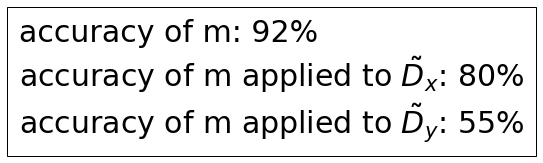

In [ ]:
text=[]
text.append("accuracy of m: {acc:.0%}".format(acc=accuracy))
text.append(r"accuracy of m applied to $\tilde{{D}}_x$: {acc:.0%}".format(acc=accuracy_tildeDx))
text.append(r"accuracy of m applied to $\tilde{{D}}_y$: {acc:.0%}".format(acc=accuracy_tildeDy))
textbox(text,fname="permutationimportance")

In [ ]:
def permutex():
    temp=data.copy()
    temp["x"]=sklearn.utils.shuffle(temp["x"].values)
    return 1-numpy.mean(numpy.abs(model(temp[["x","y"]])-temp["label"]))

def permutey():
    temp=data.copy()
    temp["y"]=sklearn.utils.shuffle(temp["y"].values)
    return 1-numpy.mean(numpy.abs(model(temp[["x","y"]])-temp["label"]))

In [ ]:
permutey()

0.5

In [ ]:
N_samples=100
numpy.random.seed(SEED)

permutex_accuracies=numpy.mean([permutex() for n in range(N_samples)])
permutey_accuracies=numpy.mean([permutey() for n in range(N_samples)])

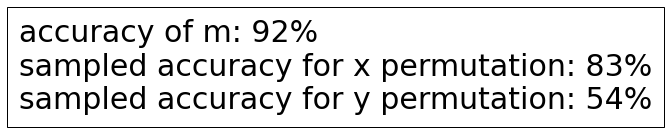

In [ ]:
text=[]
text.append("accuracy of m: {acc:.0%}".format(acc=accuracy))
text.append(r"sampled accuracy for x permutation: {acc:.0%}".format(acc=permutex_accuracies))
text.append(r"sampled accuracy for y permutation: {acc:.0%}".format(acc=permutey_accuracies))
textbox(text,fname="sampledpermutationimportance")

In [ ]:
def model_10(x):
    return model(pandas.concat([pandas.Series(x,index=data.index,dtype=float),data["y"]],axis="columns")).mean()

def model_01(y):
    return model(pandas.concat([data["x"],pandas.Series(y,index=data.index,dtype=float)],axis="columns")).mean()

def model_00():
    return model(data[["x","y"]]).mean()

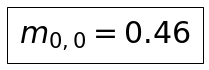

In [ ]:
text=[]
text.append(r"$m_{{0,0}}={:.2f}$".format(model_00()))
textbox(text,fname="model00")

C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings.

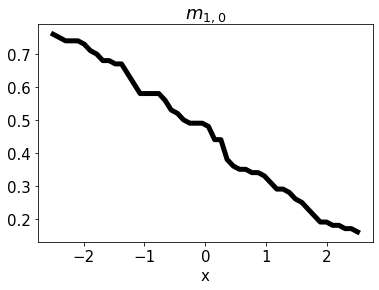

In [ ]:
xylinspace=list(numpy.linspace(-xymax,xymax))
plt.figure()
plt.plot(xylinspace,list(map(model_10,xylinspace)),color="black")
title=[]
title.append(r"$m_{{1,0}}$")
plt.title("\n".join(title))
plt.xlabel("x")
saver("model10")
plt.show()
plt.close()

C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings.

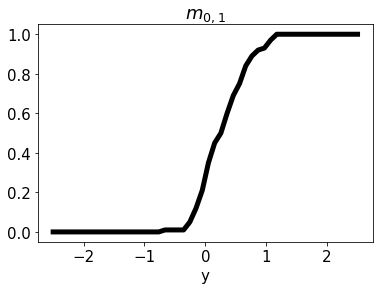

In [ ]:
xylinspace=list(numpy.linspace(-xymax,xymax))
plt.figure()
title=[]
title.append(r"$m_{{0,1}}$")
plt.title("\n".join(title))
plt.plot(xylinspace,list(map(model_01,xylinspace)),color="black")
plt.xlabel("y")
saver("model01")
plt.show()
plt.close()

In [ ]:
Accmodel_11=1-numpy.abs(model(data[["x","y"]])-data["label"]).mean()
Accmodel_00=1-numpy.abs(model_00()-data["label"]).mean()
Accmodel_10=1-numpy.abs(data["x"].apply(model_10)-data["label"]).mean()
Accmodel_01=1-numpy.abs(data["y"].apply(model_01)-data["label"]).mean()

C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings.

C:\Users\richa\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitte

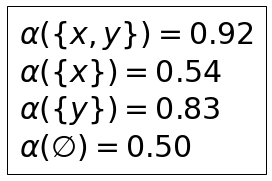

In [ ]:
text=[]
text.append(r"$\alpha(\{{x,y\}})={:.2f}$".format(Accmodel_11))
text.append(r"$\alpha(\{{x\}})={:.2f}$".format(Accmodel_10))
text.append(r"$\alpha(\{{y\}})={:.2f}$".format(Accmodel_01))
text.append(r"$\alpha(\emptyset)={:.2f}$".format(Accmodel_00))
textbox(text,fname="accuracies")

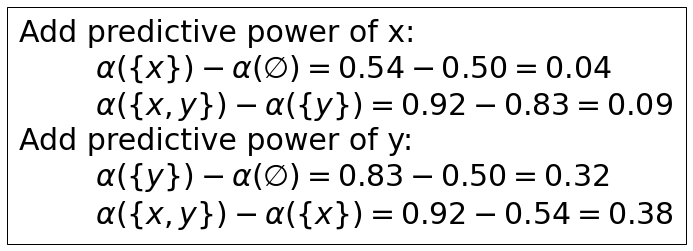

In [ ]:
text=[]
text.append("Add predictive power of x:")
text.append("\t"+r"$\alpha(\{{x\}})-\alpha(\emptyset)={0:.2f}-{1:.2f}={2:.2f}$".format(Accmodel_10,Accmodel_00,Accmodel_10-Accmodel_00))
text.append("\t"+r"$\alpha(\{{x,y\}})-\alpha(\{{y\}})={0:.2f}-{1:.2f}={2:.2f}$".format(Accmodel_11,Accmodel_01,Accmodel_11-Accmodel_01))
text.append("Add predictive power of y:")
text.append("\t"+r"$\alpha(\{{y\}})-\alpha(\emptyset)={0:.2f}-{1:.2f}={2:.2f}$".format(Accmodel_01,Accmodel_00,Accmodel_01-Accmodel_00))
text.append("\t"+r"$\alpha(\{{x,y\}})-\alpha(\{{x\}})={0:.2f}-{1:.2f}={2:.2f}$".format(Accmodel_11,Accmodel_10,Accmodel_11-Accmodel_10))
textbox(text,fname="daccuracies")

In [ ]:
shapley_x=0.5*(Accmodel_11-Accmodel_01)+0.5*(Accmodel_10-Accmodel_00)
shapley_y=0.5*(Accmodel_11-Accmodel_10)+0.5*(Accmodel_01-Accmodel_00)

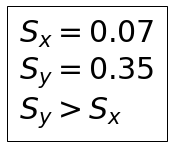

In [ ]:
text=[]
text.append(r"$S_x={0:.2f}$".format(shapley_x))
text.append(r"$S_y={0:.2f}$".format(shapley_y))
text.append(r"$S_y>S_x$")
textbox(text,fname="Shapley")